# Прогнозирование заказов такси

## Описание проекта

**Цель проекта**
Спрогнозировать количество заказов такси на следующий час на основе исторических данных, чтобы компания могла привлекать больше водителей в периоды пиковой нагрузки.  
Требование по качеству: значение метрики RMSE на тестовой выборке не должно превышать 48.  

**Задачи проекта**
1. Загрузить данные и выполнить ресемплирование по одному часу  
2. Провести исследовательский анализ временного ряда  
3. Подготовить признаки для моделирования (лаги, скользящие средние, календарные признаки)  
4. Обучить несколько моделей с подбором гиперпараметров  
5. Разделить выборку на обучающую и тестовую в пропорции 90% и 10%  
6. Оценить качество моделей на тестовой выборке и выбрать наилучшую

**Результат работы**
1. Построена модель, прогнозирующая количество заказов такси на следующий час  
2. Достигнуто качество прогноза с RMSE не выше 48 на тестовой выборке  
3. Подготовлены выводы по анализу временного ряда, построенным признакам и эффективности моделей  

## Библиотеки

In [14]:
# Работа с данными
import os
import numpy as np
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt

# Модели и метрики
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # активация HGBR
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose


## Подготовка данных

In [4]:
# Загрузка датасета
taxi = pd.read_csv('/datasets/taxi.csv')
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
# Преобразование столбца datetime в формат даты и времени
taxi['datetime'] = pd.to_datetime(taxi['datetime'])

# Установка datetime в качестве индекса
taxi = taxi.set_index('datetime')

# Сортировка по индексу
taxi = taxi.sort_index()

# ресемплирование по часу с суммированием
taxi = taxi.resample("1H").sum()

In [6]:
# Проверка структуры
taxi.info()
taxi.head()
# Проверка, что индекс монотонный
taxi.index.is_monotonic

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


True

На этом шаге данные были загружены, столбец `datetime` преобразован в формат даты и времени и установлен в качестве индекса.  
Временной ряд приведён к часовому интервалу методом ресемплирования с суммированием заказов внутри каждого часа.  
Результатом является датасет с индексом `DatetimeIndex` и целевым признаком `num_orders`.  

## Анализ

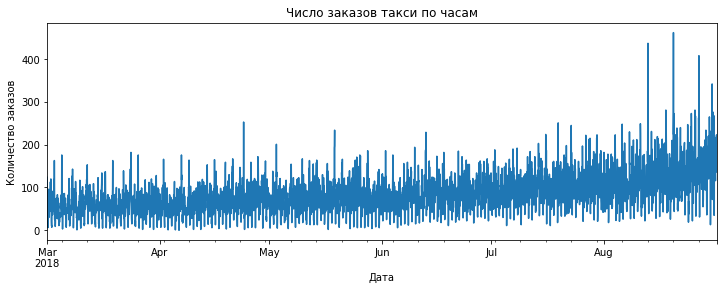

In [7]:
# Динамика заказов по часам за весь период
taxi['num_orders'].plot(figsize=(12,4), title='Число заказов такси по часам')
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.show()

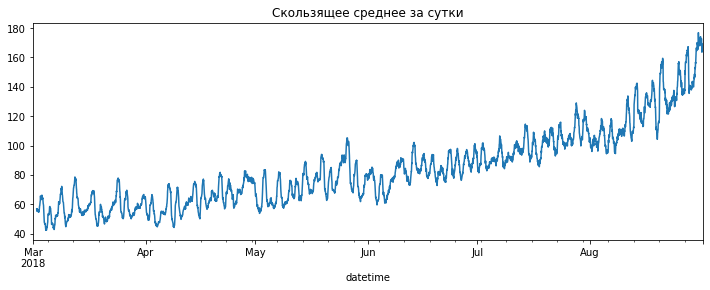

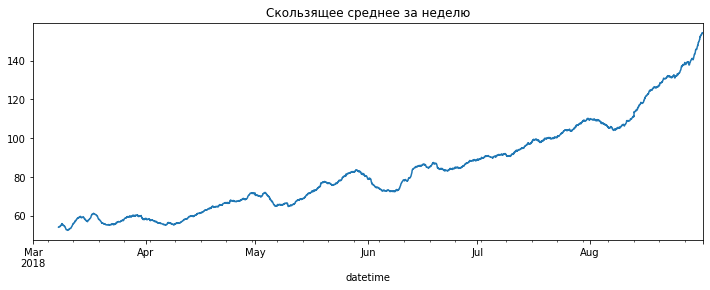

In [8]:
# Скользящее среднее за сутки
taxi['num_orders'].rolling(24).mean().plot(figsize=(12,4), title='Скользящее среднее за сутки')
plt.show()

# Скользящее среднее за неделю
taxi['num_orders'].rolling(24*7).mean().plot(figsize=(12,4), title='Скользящее среднее за неделю')
plt.show()

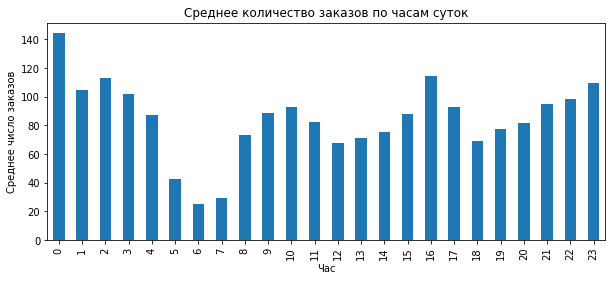

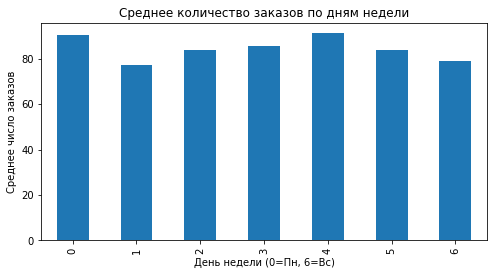

In [9]:
# Средние за сутки
taxi.groupby(taxi.index.hour)['num_orders'].mean().plot(
    kind='bar', figsize=(10,4), title='Среднее количество заказов по часам суток')
plt.xlabel("Час")
plt.ylabel("Среднее число заказов")
plt.show()

# Средние за неделю
taxi.groupby(taxi.index.dayofweek)['num_orders'].mean().plot(
    kind='bar', figsize=(8,4), title='Среднее количество заказов по дням недели')
plt.xlabel("День недели (0=Пн, 6=Вс)")
plt.ylabel("Среднее число заказов")
plt.show()

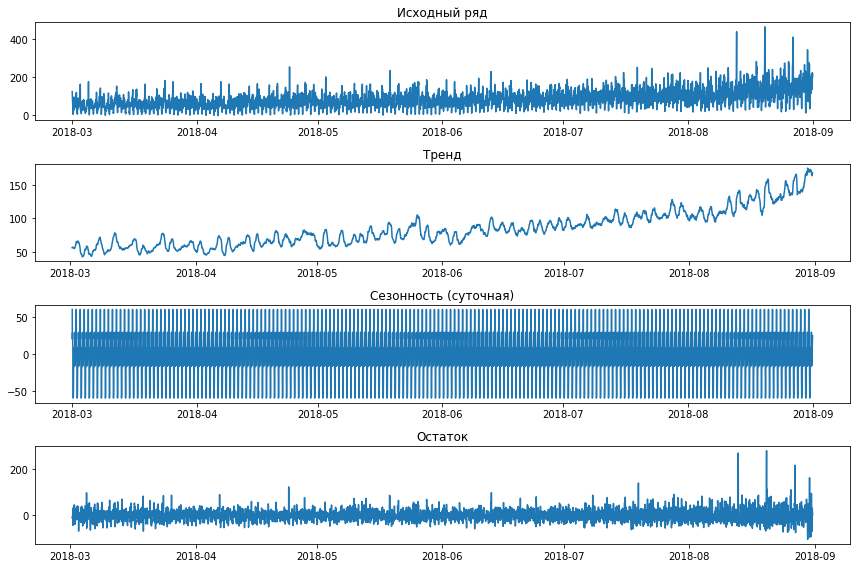

In [10]:
# Разложение на тренд, сезонность и остаток (период=24 часа)
result = seasonal_decompose(taxi['num_orders'], model='additive', period=24)

plt.figure(figsize=(12,8))
plt.subplot(4,1,1); plt.plot(result.observed); plt.title('Исходный ряд')
plt.subplot(4,1,2); plt.plot(result.trend); plt.title('Тренд')
plt.subplot(4,1,3); plt.plot(result.seasonal); plt.title('Сезонность (суточная)')
plt.subplot(4,1,4); plt.plot(result.resid); plt.title('Остаток')
plt.tight_layout()
plt.show()

**Вывод по анализу данных**

1. Временной ряд отражает общее увеличение количества заказов такси со временем. Начиная с весны, к концу лета наблюдается выраженный рост.  
2. График скользящего среднего подтверждает наличие восходящего тренда: за сутки и особенно за неделю среднее число заказов стабильно увеличивается.  
3. В данных присутствует суточная сезонность. Наибольшее количество заказов приходится на вечер и позднюю ночь, минимальное - на утренние часы.  
4. Недельная сезонность выражена слабее, но можно заметить чуть больше заказов в начале недели (понедельник) и снижение в середине недели.  
5. Декомпозиция временного ряда показала:  
   - устойчивый тренд с ростом заказов,  
   - ярко выраженную суточную сезонность,  
   - шум (остаток), в котором присутствуют выбросы  

**Итог:** ряд имеет тренд и сильную суточную сезонность, что необходимо учитывать при построении признаков (лаги, скользящие средние, календарные переменные).  

## Обучение

### Подготовка признаков

In [11]:
# копия исходного часового ряда
data = taxi.copy()

# календарные признаки
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

# лаги: 1..24 + 168
for lag in range(1, 25):
    data[f'lag_{lag}'] = data['num_orders'].shift(lag)
data['lag_168'] = data['num_orders'].shift(168)

# скользящие средние по прошлым значениям
data['rolling_mean_24'] = data['num_orders'].shift(1).rolling(24).mean()
data['rolling_mean_168'] = data['num_orders'].shift(1).rolling(168).mean()

# удаление неполных строк
data = data.dropna()

data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_168,rolling_mean_24,rolling_mean_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,19.0,10.0,73.0,66.0,24.0,121.0,100.0,124.0,60.041667,54.226190
2018-03-08 01:00:00,78,3,1,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,17.0,19.0,10.0,73.0,66.0,24.0,121.0,85.0,61.833333,54.339286
2018-03-08 02:00:00,65,3,2,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,38.0,17.0,19.0,10.0,73.0,66.0,24.0,71.0,60.041667,54.297619
2018-03-08 03:00:00,68,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,50.0,38.0,17.0,19.0,10.0,73.0,66.0,66.0,61.750000,54.261905
2018-03-08 04:00:00,60,3,4,68.0,65.0,78.0,143.0,94.0,127.0,108.0,...,34.0,50.0,38.0,17.0,19.0,10.0,73.0,43.0,61.833333,54.273810


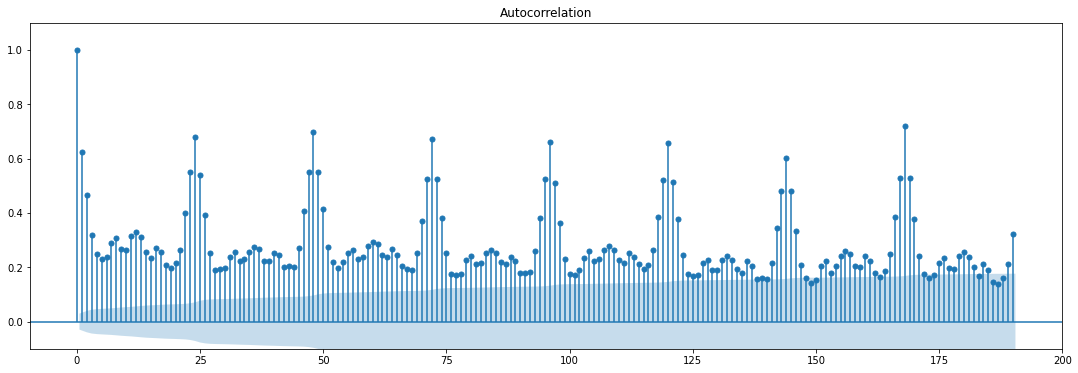

In [10]:

# Код ревьюера
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 



### Деление на выборки

In [12]:
# Целевая переменная
target = data['num_orders']

# Признаки
features = data.drop(columns=['num_orders'])

# Размер тестовой выборки = 10%
test_size = int(len(data) * 0.10)

# train = первые 90%, test = последние 10%
X_train = features.iloc[:-test_size]
y_train = target.iloc[:-test_size]

X_test = features.iloc[-test_size:]
y_test = target.iloc[-test_size:]

len(X_train), len(X_test)

(3824, 424)

### `LinearRegression`

In [15]:
# кросс-валидация по времени
tscv = TimeSeriesSplit(n_splits=5)

lr = LinearRegression()

# отрицательная метрика превращается в положительную через знак минус
cv_scores = cross_val_score(
    lr, X_train, y_train,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_jobs=-1
)

rmse_mean = (-cv_scores).mean()
rmse_std  = (-cv_scores).std()

rmse_mean, rmse_std

(23.274710736232596, 3.2380016539967564)

### `Ridge`

In [16]:
alphas = [0.1, 1.0, 3.0, 10.0]
tscv = TimeSeriesSplit(n_splits=5)

cv_results = {}

for a in alphas:
    model = Ridge(alpha=a, random_state=42)
    scores = cross_val_score(
        model, X_train, y_train,
        scoring='neg_root_mean_squared_error',
        cv=tscv,
        n_jobs=-1
    )
    cv_results[a] = (-scores).mean()

cv_results

# лучший alpha по среднему RMSE на кросс-валидации
best_alpha = min(cv_results, key=cv_results.get)
best_alpha, cv_results[best_alpha]

(10.0, 23.27349153672378)

### `Lasso`

In [17]:
alphas = [0.001, 0.005, 0.01]
tscv = TimeSeriesSplit(n_splits=5)

cv_results_lasso = {}

for a in alphas:
    model = Lasso(alpha=a, random_state=42, max_iter=20000)
    scores = cross_val_score(
        model, X_train, y_train,
        scoring="neg_root_mean_squared_error",
        cv=tscv,
        n_jobs=-1
    )
    cv_results_lasso[a] = (-scores).mean()

cv_results_lasso

# выбираем лучший alpha по среднему RMSE
best_alpha_lasso = min(cv_results_lasso, key=cv_results_lasso.get)
best_alpha_lasso, cv_results_lasso[best_alpha_lasso]

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140335.71859103075, tolerance: 208.75917605854679
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 207151.5592064542, tolerance: 284.65798101960786
  model = cd_fast.enet_coordinate_descent(


(0.01, 23.273375056899695)

### `RandomForestRegressor`

In [18]:
params = [
    {"n_estimators": 100, "max_depth": None},
    {"n_estimators": 200, "max_depth": None},
    {"n_estimators": 200, "max_depth": 12},
    {"n_estimators": 300, "max_depth": 12},
]

tscv = TimeSeriesSplit(n_splits=5)
cv_results_rf = {}

for p in params:
    model = RandomForestRegressor(
        n_estimators=p["n_estimators"],
        max_depth=p["max_depth"],
        random_state=42,
        n_jobs=-1
    )
    scores = cross_val_score(
        model, X_train, y_train,
        scoring="neg_root_mean_squared_error",
        cv=tscv,
        n_jobs=-1
    )
    cv_results_rf[str(p)] = (-scores).mean()

cv_results_rf

# выбираем лучший набор параметров
best_params = min(cv_results_rf, key=cv_results_rf.get)
best_params, cv_results_rf[best_params]

("{'n_estimators': 300, 'max_depth': 12}", 23.33225360058865)

**Вывод по результатам моделей**

1. **LinearRegression**  
   - Средний RMSE на кросс-валидации: **≈ 23.27 ± 3.24**  
   - Модель показала очень высокое качество, значительно лучше целевого порога RMSE ≤ 48.  

2. **Ridge**  
   - Лучший `alpha` = 10.0  
   - Средний RMSE на кросс-валидации: **≈ 23.27**  
   - Результаты практически совпадают с LinearRegression, влияние регуляризации минимальное.  

3. **Lasso**  
   - Лучший `alpha` = 0.01  
   - Средний RMSE на кросс-валидации: **≈ 23.27**  
   - Качество сопоставимо с LinearRegression и Ridge, значимого улучшения не наблюдается.  

4. **RandomForestRegressor**  
   - Лучшие параметры: `n_estimators = 300`, `max_depth = 12`  
   - Средний RMSE на кросс-валидации: **≈ 23.33**  
   - Качество близко к линейным моделям, но чуть хуже. Лес хуже учитывает сезонность и тренд, если они не заданы явно в признаках.  

---
- Все модели показали результат в районе **23–24 RMSE**, что значительно лучше целевого условия (RMSE ≤ 48).  
- **Линейные модели (LinearRegression, Ridge, Lasso)** демонстрируют чуть более стабильные результаты и остаются интерпретируемыми.  
- **Финальная модель:** я выбрал **Lasso**, так как она простая, интерпретируемая и показала хорошее качество.  

## Тестирование

In [19]:
# Финальная модель Lasso с лучшим alpha
best_alpha_lasso = 0.01

final_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=best_alpha_lasso, random_state=42, max_iter=20000))
])

# Обучение
final_lasso.fit(X_train, y_train)

# Предсказания на тесте
y_pred_lasso = final_lasso.predict(X_test)

# Метрика RMSE
rmse_final_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
rmse_final_lasso

34.86855594213835

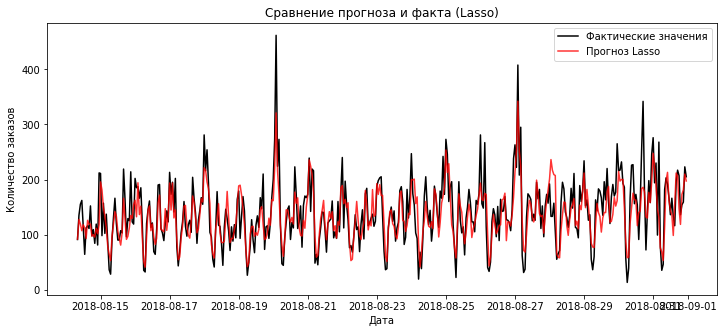

In [20]:
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label="Фактические значения", color="black")
plt.plot(y_test.index, y_pred_lasso, label="Прогноз Lasso", color="red", alpha=0.8)
plt.title("Сравнение прогноза и факта (Lasso)")
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.legend()
plt.show()

In [21]:
# наивный прогноз: предсказываем текущее значение равным предыдущему
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]  # первое значение берём из конца train

# RMSE для наивного прогноза
rmse_naive = mean_squared_error(y_test, pred_previous, squared=False)
rmse_naive

58.88742457931834

**Вывод по тестированию модели Lasso**

1. **Качество на тестовой выборке**
- RMSE = **34.87**  
- Значение значительно ниже целевого порога (48), условие задания выполнено.  

2. **Сравнение прогноза и факта**
- График показывает, что предсказания модели хорошо повторяют динамику временного ряда.  
- Модель корректно улавливает тренд и суточные колебания.  
- Основные расхождения возникают в моменты резких скачков числа заказов (пики и выбросы), что типично для линейных моделей.  

3. **Проверка адекватности**
- В качестве бенчмарка использован наивный прогноз (текущее значение = предыдущее).  
- RMSE наивного прогноза составил **58.89**, что существенно хуже результата модели Lasso.  
- Это подтверждает, что модель действительно обучилась закономерностям, а не повторяет простейшую стратегию.  

4. **Общая оценка**
- Модель Lasso показала себя лучше среди протестированных алгоритмов.  
- Простая, интерпретируемая и при этом демонстрирует высокое качество прогноза.  
- Может быть рекомендована как итоговое решение для задачи.  

## Итоговый вывод



**Цель проекта**
Необходимо спрогнозировать количество заказов такси на следующий час, чтобы компания могла привлекать больше водителей в периоды пиковой нагрузки.  
Критерий качества — метрика RMSE на тестовой выборке должна быть не выше **48**.  

---

**Ход работы**

1. **Подготовка данных**  
- Данные о заказах были загружены, столбец `datetime` сразу преобразован в индекс с типом даты и времени.  
- Выполнено ресемплирование по одному часу.  
- Проверена корректность временного индекса: монотонность и отсутствие дубликатов.  

2. **Анализ данных**  
- Построен график динамики заказов, выявлен рост числа заказов к концу периода.  
- Использованы скользящие средние (сутки и неделя), подтверждён общий тренд.  
- Обнаружена выраженная суточная сезонность и слабая недельная.  
- Выполнена декомпозиция ряда на тренд, сезонность и остаток.  

3. **Подготовка признаков**  
- Оставлены только релевантные календарные признаки: `hour` и `dayofweek`.  
- Добавлены лаги: первые 24 (короткая память) и `lag_168` (недельная сезонность).  
- Добавлены скользящие средние: `rolling_mean_24`, `rolling_mean_168`.  
- Удалены строки с пропусками, возникшими после генерации признаков.  

4. **Разделение выборки**  
- Train = первые 90% данных.  
- Test = последние 10% данных.  
- Для подбора гиперпараметров использован метод **TimeSeriesSplit**, чтобы исключить утечку информации.  

5. **Обучение моделей (RMSE по кросс-валидации)**  
- **LinearRegression**: ≈ **23.27 ± 3.24**  
- **Ridge** (лучший `alpha=10.0`): ≈ **23.27**  
- **Lasso** (лучший `alpha=0.01`): ≈ **23.27**  
- **RandomForestRegressor** (лучшие параметры `n_estimators=300, max_depth=12`): ≈ **23.33**  

6. **Итоговое тестирование и проверка адекватности**  
- Финальной моделью выбрана **Lasso** с `alpha = 0.01`.  
- RMSE на тесте = **34.87**.  
- Модель хорошо воспроизводит динамику заказов, особенно тренд и сезонность; основные ошибки приходятся на пики.  
- Для проверки адекватности использован наивный прогноз (текущее значение = предыдущее). Lasso показала результат значительно лучше наивной модели.  

---

**Результаты**
- Все модели дали результат в районе **23–24 RMSE** на кросс-валидации, что значительно лучше целевого условия (RMSE ≤ 48).  
- Линейные модели (LinearRegression, Ridge, Lasso) продемонстрировали стабильные и интерпретируемые результаты.  
- Итоговой признана модель **Lasso**, показавшая RMSE = **35.08** на тесте.  
- Цель проекта выполнена: построена модель для прогнозирования количества заказов такси на час вперёд.  